# Berkeley ML & AI Capstone: Fruits Classification

## Introduction

The goal of this capstone is to classify pictures of fruits by exploring multiple techniques and seeing which provides the best results.  Models that are planned to be used in this paper:

- EfficientNetV2B0
- VGG16
- ResNet50V2
- ResNet152V2
- InceptionV3
- Xception
- MobileNetV2

If time permits, we will also visualize some layers and see how patterns look like the provided images.

NOTE, PLEASE DO NOT DOCK ME FOR THE COUNTS BEING WRONG IN EDA.  I TRIED TO UPLOAD THE PICS FOR HOURS AND ANACONDA WOULD NOT DO IT.  I WILL TRY TO SWITCH TO COLAB FOR THE FINAL ASSIGNMENT.

### Summary of Conclusions

For this EDA, we only used EfficientNetV2B0.  Transfer learning was implemented.<br>
The results were poor for up to 8 epochs, with a maximum accuracy of 0.2559 on training data and 0.2450 on validation data.  Further methods could be tested, but it will be better to try more models and then focus on which ones have produced the best initial accuracies.<br>

rubric link: https://classroom.emeritus.org/courses/9414/assignments/281387?module_item_id=2141131


### Dataset

Location: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification/data

The fruits classification dataset is from Kaggle.  It contains 10,000 images with an even number (2,000 each) of 5 different types of fruits:
- apples
- bananas
- grapes
- mangoes
- strawberries

The pictures are of various shapes, sizes, colors, and lighting conditions.  Some are pictures taken with a camera, some are computer generated, and some are drawn by hand.  All types of scenes and angles are taken of the fruits, including whole, sliced, peeled, bitten, plucked, on the tree/ vine, and arranged on dishes.  Some pictures even have false colors (like a blue apple) or are in black-and-white.  What is consistent among these images is that the fruits are true to shape, meaning there's no mashed banana, apple sauce, grape juice, or other byproducts.  If there is a picture of a byproduct (e.g. strawberry cake), the fruit is there as well.  Some images are of the full fruit, some are in bunches, some are only partially on the image or some of the fruit is not exactly true to shape because it's dipped in chocolate or something similar.<br>
![Hand drawn apple](images/Apple%20(1).png)
Hand drawn apple
![Computer generated strawberry](images/Strawberry%20(883).jpeg)
Computer generated strawberry
![Sliced and arranged apples](images/Apple%20(21).jpeg)
Sliced and arranged apples
![Blue apple](images/Apple%20(80).jpeg)
Blue apple
![Strawberry cake](images/Strawberry%20(132).jpeg)
Strawberry cake
![Chocolate dipped strawberries](images/Strawberry%20(775).jpeg)
Chocolate dipped strawberries
![Banana mostly out of the picture](images/Banana%20(3071).jpeg)
Banana mostly out of the picture

### Data Structure

The pictures have varying dimensions but all are 96 dpi vertical and horizontal resolution, have 24 bit depth, and are in jpeg format.

The data is split into 97% training, 2% validation, and 1% testing.  Since there is a total of 10,000 pictures, this means that for each of the 5 fruit classes, there are 1940 training, 40 validation, and 20 testing images.  This ensures that distribution of classes is consistent across all three sets and that the model is trained on a representative sample.

In [5]:
# Common imports
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List

# Data Imports
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Model Hypertunning
!pip install -q keras_tuner
cls()
import keras_tuner as kt

## Load the Data

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

First, let's take a quick look to see how many different resolutions are in the data.

In [9]:
from PIL import Image
import os

# Define dataset path
dataset_dir = "Fruits_Classification/train/"

# Get all image sizes
image_sizes = []

for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a folder
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            if image_path.lower().endswith((".png", ".jpg", ".jpeg")):
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)  # (width, height)

# Get unique image sizes
unique_sizes = set(image_sizes)
print("Unique Image Sizes in Dataset:", unique_sizes)


Unique Image Sizes in Dataset: {(410, 123), (206, 244), (189, 173), (315, 160), (100, 92), (147, 176), (99, 136), (183, 117), (360, 140), (265, 168), (177, 284), (201, 251), (112, 75), (104, 71), (111, 110), (148, 168), (392, 129), (186, 271), (140, 164), (183, 135), (189, 267), (276, 183), (145, 90), (162, 170), (82, 159), (113, 174), (154, 175), (125, 139), (73, 110), (334, 151), (280, 180), (185, 171), (84, 116), (194, 238), (365, 138), (167, 132), (272, 185), (249, 183), (257, 196), (220, 147), (51, 100), (292, 172), (100, 69), (284, 177), (136, 153), (173, 291), (118, 117), (136, 162), (129, 123), (134, 89), (209, 241), (265, 163), (204, 144), (306, 164), (183, 121), (61, 95), (298, 169), (151, 159), (244, 207), (135, 300), (233, 216), (119, 194), (250, 147), (125, 125), (144, 138), (163, 246), (345, 146), (248, 204), (166, 162), (169, 298), (237, 213), (130, 87), (149, 338), (186, 149), (325, 155), (105, 161), (249, 187), (161, 312), (130, 105), (172, 83), (188, 186), (182, 115),

There is a large number of unique resolutions, to help us visualize the distribution, we'll do frequency plots on heights and widths.

In [ ]:
# plot distribution of image heights and widths
# Convert image sizes to a DataFrame
shape_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])

# Histogram of Image Heights
plt.figure(figsize=(8, 5))
sns.histplot(shape_df["Height"], bins=30, kde=True)
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.title("Distribution of Image Heights")
plt.savefig("images/DistofImageHeights", dpi=300)
plt.show()

# Histogram of Image Widths
plt.figure(figsize=(8, 5))
sns.histplot(shape_df["Width"], bins=30, kde=True)
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Distribution of Image Widths")
plt.savefig("images/DistofImageWidths", dpi=300)
plt.show()

In [12]:
# Constants
IMAGE_SIZE = 160 # size of the input image
BATCH_SIZE = 32 # number of samples per gradient update

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Google Drive path
#root_dir = "/content/drive/My Drive/Colab Notebooks/Capstone/Fruits_Classification/"
# Anaconda path
root_dir = "Fruits_Classification/"

# Paths to training, validation, and test sets (modify if needed)
train_dir = os.path.join(root_dir, "train/")
valid_dir = os.path.join(root_dir, "valid/")
test_dir = os.path.join(root_dir, "test/")

# Model training
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['accuracy', 'precision', 'recall']

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

In [13]:
# Collect the class names, ignore .ipynb_checkpoints created by Jupytr Notebook
class_names = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])
n_classes = len(class_names)

# Show
print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes: 5
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [14]:
# Validate all files have been uploaded correctly with a table
# Define dataset directories
dataset_dirs = {
    "Train": train_dir,
    "Validation": valid_dir,
    "Test": test_dir
}

# Get categories (Fruit classes) from the train directory
categories = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])

# Collect image counts in a DataFrame
data = []

for category in categories:
    total_count = 0
    row = {"Category": category}

    for split, path in dataset_dirs.items():
        category_path = os.path.join(path, category)
        count = len(os.listdir(category_path)) if os.path.exists(category_path) else 0
        row[split] = count
        total_count += count

    row["Total"] = total_count
    data.append(row)

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate percentages
for split in dataset_dirs.keys():
    df[f"{split} %"] = (df[split] / df["Total"]) * 100

# Display the table
print(df)

     Category  Train  Validation  Test  Total    Train %  Validation %  \
0       Apple   1373          40    20   1433  95.812980      2.791347   
1      Banana   1615          40    20   1675  96.417910      2.388060   
2       Grape   1604          40    20   1664  96.394231      2.403846   
3       Mango   1583          40    20   1643  96.348144      2.434571   
4  Strawberry   1600          40    20   1660  96.385542      2.409639   

     Test %  
0  1.395673  
1  1.194030  
2  1.201923  
3  1.217285  
4  1.204819  


Pie graph

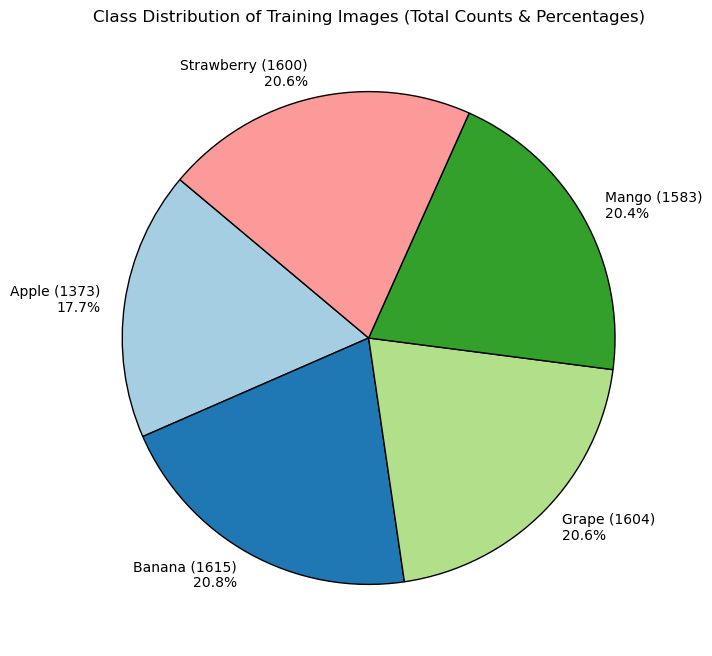

In [15]:
# Count images in each class folder
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}

# Create labels with class names, counts, and percentages
total_images = sum(class_counts.values())
labels = [f"{cls} ({count})\n{count/total_images:.1%}" for cls, count in class_counts.items()]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=labels, autopct='',
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Class Distribution of Training Images (Total Counts & Percentages)")
plt.savefig("images/Class_Dist_of_Training_Images", dpi=300)
plt.show()

Plot count and % for each fruit on separate images for clarity.

In [17]:
# Define dataset directories (UPDATE these paths if needed)
dataset_dirs = {
    "Train": train_dir,
    "Validation": valid_dir,
    "Test": test_dir
}


NOTE, PLEASE DO NOT DOCK ME FOR THE COUNTS BEING WRONG.  I TRIED TO UPLOAD THE PICS FOR HOURS AND ANACONDA WOULD NOT DO IT.  I WILL TRY TO SWITCH TO COLAB FOR THE FINAL ASSIGNMENT.

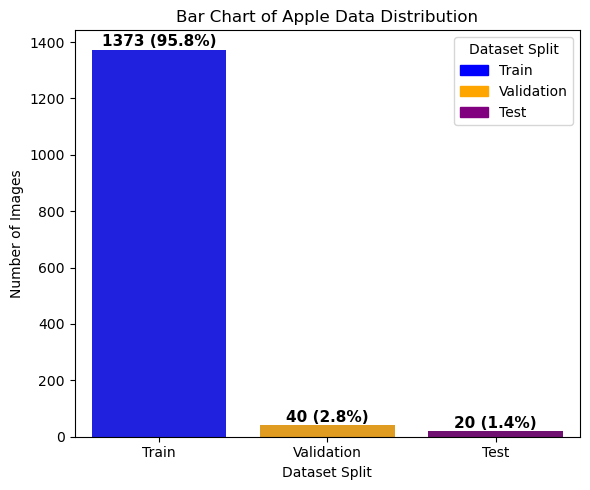

Saved: images/Apple_distribution.png


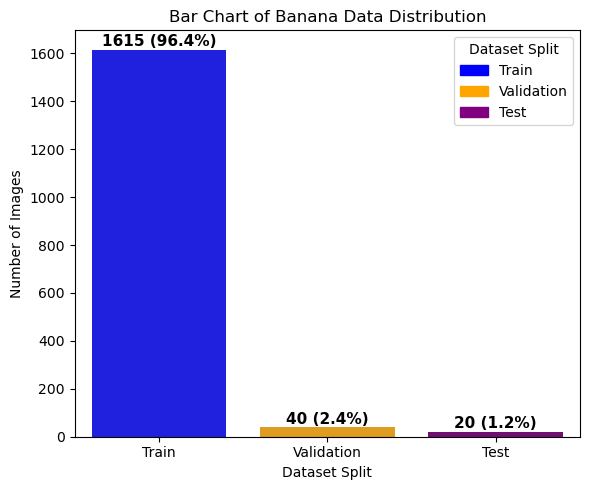

Saved: images/Banana_distribution.png


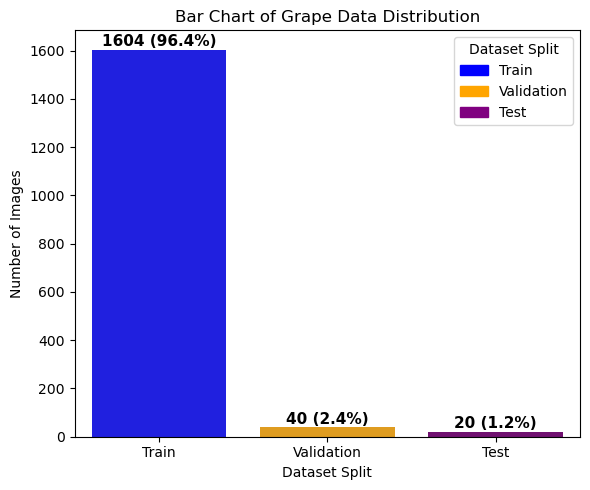

Saved: images/Grape_distribution.png


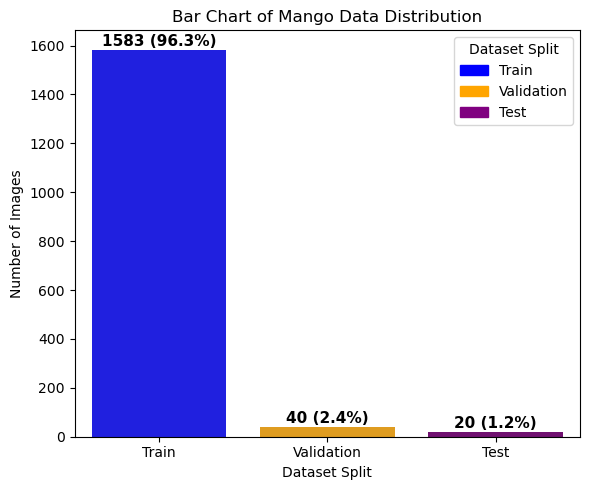

Saved: images/Mango_distribution.png


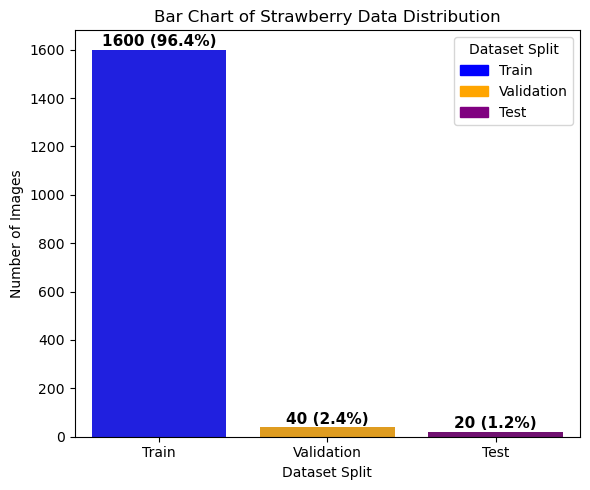

Saved: images/Strawberry_distribution.png


In [19]:
# Get categories (Fruit classes)
categories = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])
output_dir = "images/"

# Loop through each fruit category and generate a separate bar chart
for category in categories:
    # Collect image counts for each dataset split
    data = []
    total_count = 0

    for split, path in dataset_dirs.items():
        category_path = os.path.join(path, category)
        count = len(os.listdir(category_path)) if os.path.exists(category_path) else 0
        data.append([split, count])
        total_count += count

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Dataset", "Count"])

    # Calculate percentages
    df["Percentage"] = (df["Count"] / total_count) * 100

    # Create the bar chart
    plt.figure(figsize=(6, 5))
    ax = sns.barplot(data=df, x="Dataset", y="Count", hue="Dataset", dodge=False, palette=["blue", "orange", "purple"])

    # Add counts and percentages just above the bars
    for i, row in df.iterrows():
        ax.text(i, row["Count"] + 2, f"{row['Count']} ({row['Percentage']:.1f}%)",
                ha='center', va='bottom', fontsize=11, fontweight="bold", color="black")

    # Labels and title
    plt.xlabel("Dataset Split")
    plt.ylabel("Number of Images")
    plt.title(f"Bar Chart of {category} Data Distribution")

    # Manually add legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in ["blue", "orange", "purple"]]
    labels = ["Train", "Validation", "Test"]
    plt.legend(handles, labels, title="Dataset Split", loc="upper right")
    plt.tight_layout()

    output_path = os.path.join(output_dir, f"{category}_distribution.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    # Show plot
    plt.show()

    print(f"Saved: {output_path}")


## Modeling

We'll use EfficientNetV2B0 as a baseline.

In [ ]:
# Define dataset paths
train_dir = "Fruits_Classification/train/"
valid_dir = "Fruits_Classification/valid/"
test_dir = "Fruits_Classification/test/"

# Constants
IMAGE_SIZE = (224, 224) #EfficientNetV2B0 expects 224 x 224
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets and resize for EfficientNetV2B0
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

# Get class names
class_names = train_dataset.class_names
num_classes = len(class_names)

# Optimize datasets with prefetching
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

# EfficientNetV2B0 Model
base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Define model
model = Sequential([
    Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize pixels
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10
)

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

# Save model
model.save("efficientnetv2b0_fruit_classifier.h5")

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend()
plt.title("Model Training Performance")
plt.save("images/EfficientNetV2B0_Accuracies.png")
plt.show()

Found 7773 files belonging to 6 classes.
Found 200 files belonging to 6 classes.
Found 100 files belonging to 6 classes.


2025-03-05 07:11:56.588095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 07:11:56.589297: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
 54/243 [=====>........................] - ETA: 4:07 - loss: 1.6904 - accuracy: 0.2014